# Exercises

In [137]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd
from wrangle import wrangle_data

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

spark = pyspark.sql.SparkSession.builder.getOrCreate()




In [186]:
df = wrangle_data()

In [4]:
df.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- case_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: string (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- dept_division: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: string (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = false)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: string (nullable = true)
 |-- source_username: string (nullable = true)
 |-- num_weeks_late: double (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- case_age: integer (nullable = true)
 |-- days_to_closed: integer (nullable 

### How many different cases are there, by department?

<AxesSubplot:ylabel='dept_division'>

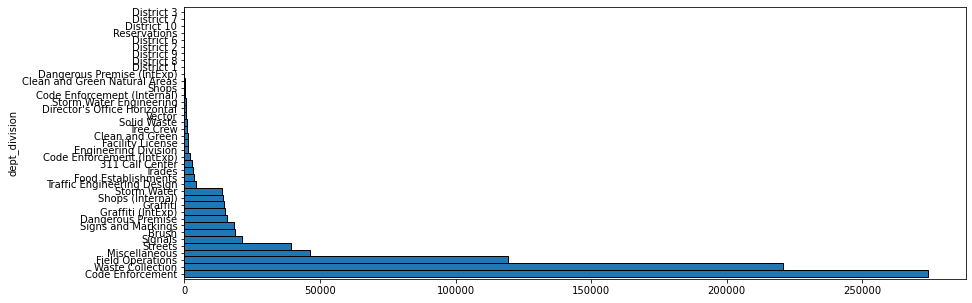

In [5]:
df.groupby('dept_division').agg(count(col('service_request_type')).alias('count'))\
.toPandas()\
    .set_index("dept_division")["count"]\
    .sort_values(ascending=False)\
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))

### Does the percentage of cases that are late vary by department?

In [24]:
df1 = df.groupby('dept_name', 'num_days_late')\
.agg(count('num_days_late').alias("count"))\
.select(df.dept_name, df.num_days_late, when(df.num_days_late >= 0, "late")\
        .otherwise("ontime").alias('status')).groupby('dept_name').pivot("status").agg(count('status')).sort(asc('dept_name')).filter(df.dept_name != 'null')\
.toPandas().set_index('dept_name')

In [25]:
df1['percent_late'] = df1.late / (df1.late + df1.ontime)*100
df1.dropna(inplace = True)

In [26]:

df1.head()

,late,ontime,percent_late
dept_name,,,
Animal Care Services,36666.0,42379,46.386236
Code Enforcement Services,26662.0,233861,10.234029
Customer Service,1870.0,709,72.508724
Development Services,816.0,521,61.032162
Metro Health,1124.0,4025,21.829481


<AxesSubplot:ylabel='dept_name'>

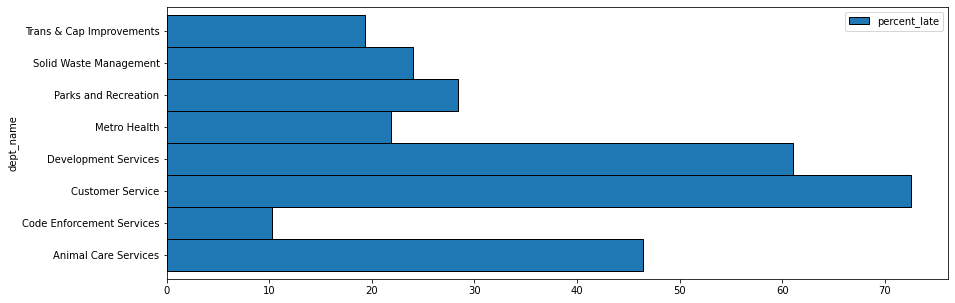

In [27]:
df1.plot.barh(width=1, edgecolor="black", figsize=(14, 5), y = 'percent_late')

### On average, how late are the late cases by department?


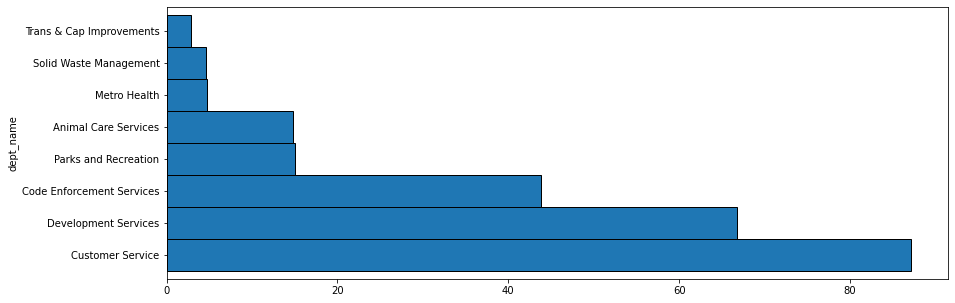

In [28]:
df2 = df.filter(df.dept_name != "None").groupby('dept_name', 'num_days_late')\
.agg(count('num_days_late').alias("count"))\
.select(df.dept_name, df.num_days_late, when(df.num_days_late >= 0, "late")\
        .otherwise("ontime").alias('status')).filter(col('status') == 'late')\
.groupby('dept_name').agg(avg('num_days_late').alias('avg_late')).toPandas().set_index("dept_name")["avg_late"]\
    .sort_values(ascending=False)\
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))

### What is the service type that is the most late? Just for Parks & Rec?


Text(0.5, 1.0, 'Avg Number of Days Late By Service Request Type')

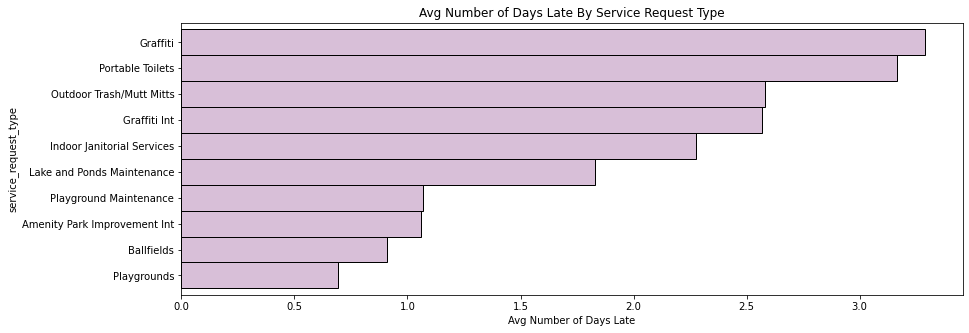

In [75]:
df.where('case_late').where(df.standardized_dept_name  == 'Parks & Recreation').groupby('service_request_type').agg(avg('num_days_late').alias('days_case_late')).toPandas().set_index('service_request_type')\
.days_case_late.sort_values().head(10).plot.barh(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Service Request Type")


### For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.


<AxesSubplot:ylabel='service_request_type'>

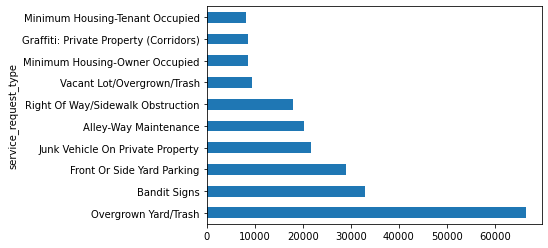

In [92]:
df.where(df.standardized_dept_name  == 'DSD/Code Enforcement').groupby('service_request_type').agg(count('service_request_type').alias('service_count'))\
.toPandas().set_index('service_request_type').service_count.sort_values(ascending = False).head(10).plot.barh()

### Does whether or not its a weekend matter for when a case is opened/closed?


In [94]:
df.show(1,vertical = True)

-RECORD 0--------------------------------------
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 00:42:00  
 case_due_date          | 2018-01-01 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 dept_division          | Field Operations     
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 source_id              | svcCRMLS             
 request_address        | 2315  el paso st,... 
 council_district       | 005                  
 dept_name              | Animal Care Services 
 standardized_dept_name | Animal Care Services 
 dept_subject_to_SLA    | YES                  
 source_username        | svcCRMLS             
 num_weeks_late         | -142.6441088         
 zipcode                | 78207         

In [107]:
df1 = df.withColumn('day_of_week', date_format('case_opened_date', 'E'))
df1.show(1, vertical = True)

-RECORD 0--------------------------------------
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 00:42:00  
 case_due_date          | 2018-01-01 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 dept_division          | Field Operations     
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 source_id              | svcCRMLS             
 request_address        | 2315  el paso st,... 
 council_district       | 005                  
 dept_name              | Animal Care Services 
 standardized_dept_name | Animal Care Services 
 dept_subject_to_SLA    | YES                  
 source_username        | svcCRMLS             
 num_weeks_late         | -142.6441088         
 zipcode                | 78207         

In [130]:
df1.where(df1.day_of_week != 'Sat').where(df1.day_of_week != 'Sun').groupby('day_of_week').pivot('case_status').agg(count(col('case_status'))\
.alias('case_count')).toPandas()

,day_of_week,Closed,Open
0,Mon,152584,3197
1,Thu,152786,3133
2,Wed,146118,3665
3,Tue,160100,4508
4,Fri,142484,2758


Text(0.5, 1.0, 'Avg Number of Days Late By Service Request Type')

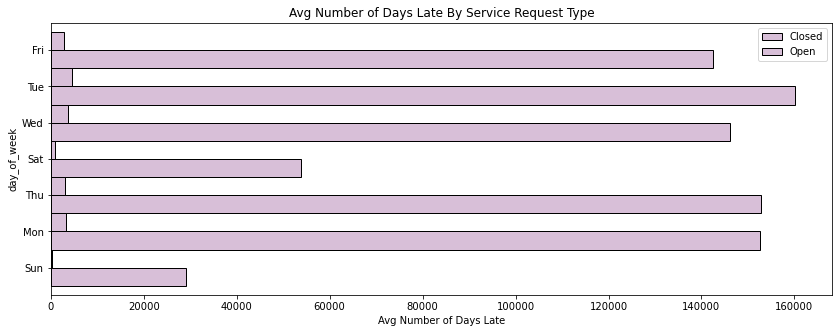

In [136]:
df1.groupby('day_of_week').pivot('case_status').agg(count(col('case_status'))\
.alias('case_count')).toPandas().set_index('day_of_week').plot.barh(width=1, edgecolor="black", color='thistle', figsize=(14, 5))
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Service Request Type")

### On average, how many cases are opened a day for the Customer Service department?


### Does the number of service requests for the solid waste department vary by day of the week?